In [813]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [814]:
args = {'lr':0.01,
        'epochs':1000,
        'noise':0.001,
        'train size':0.7,
        'spec scale':10**12,
        'input features':20,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss()
        }

In [815]:
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [816]:
df = pd.read_excel('wide_range.xlsx')

In [817]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

In [818]:

for layer in layers:
    estimator = LinearRegression(copy_X=True)
    rfe = RFE(estimator=estimator, n_features_to_select=args['input features'])

    target = y[layer['col']]

    X_selected = rfe.fit_transform(X, target)
    selected_feature_indices = rfe.get_support(indices=True)
    
    features = []
    for i in selected_feature_indices:
        features.append(X.columns[i])

    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()}:\n {features}\n')

Features for Layer 1:
 [7e-06, 7.05e-06, 7.1e-06, 7.15e-06, 7.2e-06, 7.25e-06, 7.35e-06, 7.4e-06, 7.45e-06, 7.5e-06, 7.55e-06, 7.6e-06, 7.65e-06, 7.7e-06, 7.75e-06, 7.8e-06, 7.85e-06, 7.9e-06, 7.95e-06, 8e-06]

Features for Layer 2:
 [7.05e-06, 7.1e-06, 7.15e-06, 7.2e-06, 7.25e-06, 7.3e-06, 7.35e-06, 7.4e-06, 7.45e-06, 7.5e-06, 7.55e-06, 7.6e-06, 7.65e-06, 7.7e-06, 7.75e-06, 7.8e-06, 7.85e-06, 7.9e-06, 7.95e-06, 8e-06]

Features for Layer 3:
 [7.05e-06, 7.1e-06, 7.15e-06, 7.2e-06, 7.25e-06, 7.3e-06, 7.35e-06, 7.4e-06, 7.45e-06, 7.5e-06, 7.55e-06, 7.6e-06, 7.65e-06, 7.7e-06, 7.75e-06, 7.8e-06, 7.85e-06, 7.9e-06, 7.95e-06, 8e-06]

Features for Layer 4:
 [7.05e-06, 7.1e-06, 7.15e-06, 7.2e-06, 7.25e-06, 7.3e-06, 7.35e-06, 7.4e-06, 7.45e-06, 7.5e-06, 7.55e-06, 7.6e-06, 7.65e-06, 7.7e-06, 7.75e-06, 7.8e-06, 7.85e-06, 7.9e-06, 7.95e-06, 8e-06]

Features for Layer 5:
 [7.05e-06, 7.1e-06, 7.15e-06, 7.2e-06, 7.25e-06, 7.3e-06, 7.35e-06, 7.4e-06, 7.45e-06, 7.5e-06, 7.55e-06, 7.6e-06, 7.65e-06, 7.

In [819]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X = X + noise

In [820]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=args['train size'], random_state=101)

In [821]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [822]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedForward, self).__init__()
        self.lin1 = nn.Linear(input_size, 15) 
        self.lin2 = nn.Linear(15, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin_fin = nn.Linear(5, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = self.lin_fin(x)
        return x

In [823]:
input_size = args['input features']
output_size = 1

criterion = args['train criterion']

In [824]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    model = FeedForward(input_size, output_size)

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

    print(layer['col'])

    for epoch in range(args['epochs']):
        outputs = model(input)

        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
epoch: 100, loss = 119.40575408935547
epoch: 200, loss = 88.93017578125
epoch: 300, loss = 24.505735397338867
epoch: 400, loss = 24.452058792114258
epoch: 500, loss = 24.442262649536133
epoch: 600, loss = 24.43180274963379
epoch: 700, loss = 24.423595428466797
epoch: 800, loss = 24.41629409790039
epoch: 900, loss = 24.409135818481445
epoch: 1000, loss = 24.405128479003906
best loss: 24.405128479003906 in epoch 1000

layer 2
epoch: 100, loss = 119.84964752197266
epoch: 200, loss = 113.28828430175781
epoch: 300, loss = 15.24496078491211
epoch: 400, loss = 13.955244064331055
epoch: 500, loss = 13.893625259399414
epoch: 600, loss = 13.840066909790039
epoch: 700, loss = 13.787508964538574
epoch: 800, loss = 13.74194622039795
epoch: 900, loss = 13.704034805297852
epoch: 1000, loss = 13.675004959106445
best loss: 13.675004959106445 in epoch 1000

layer 3


KeyboardInterrupt: 

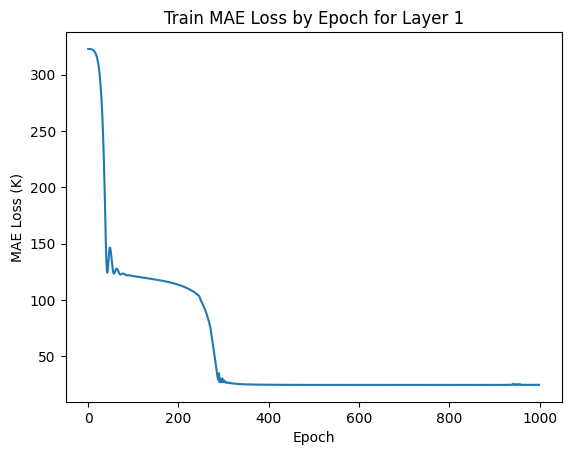

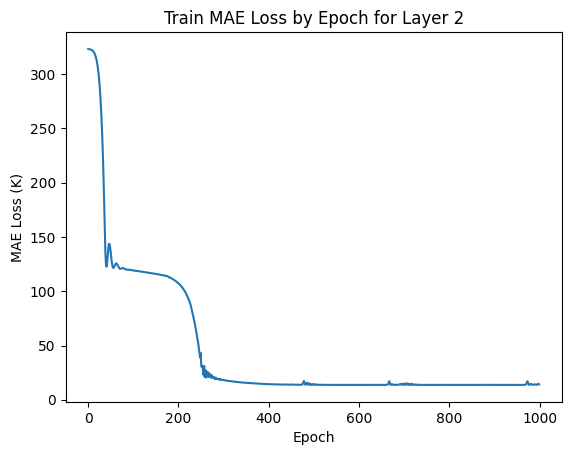

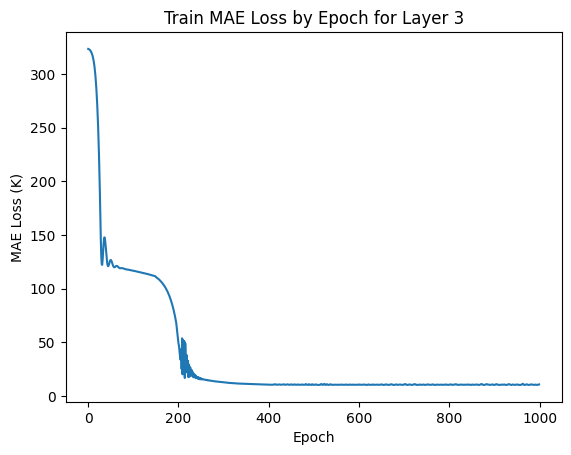

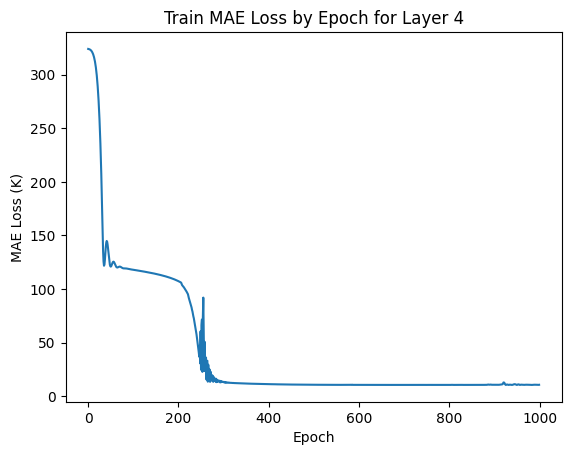

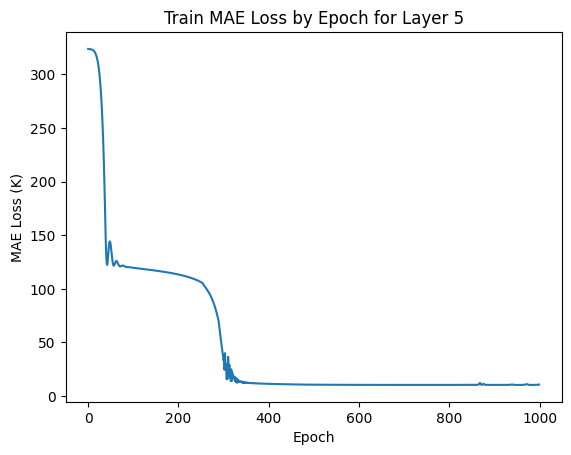

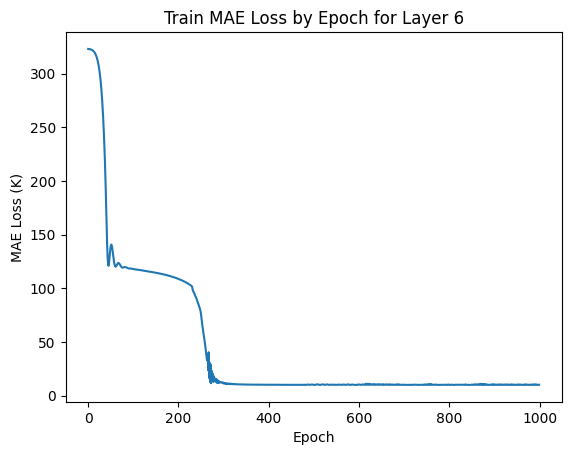

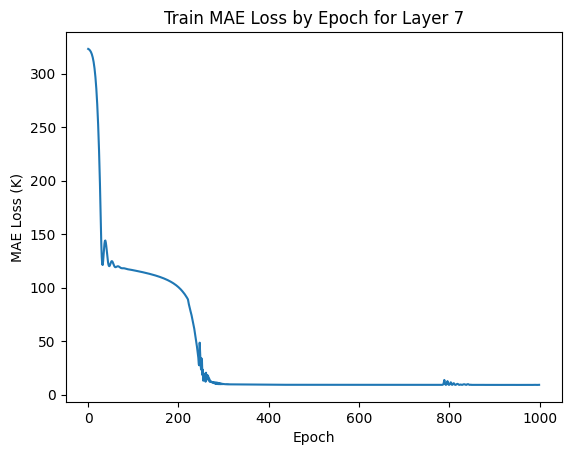

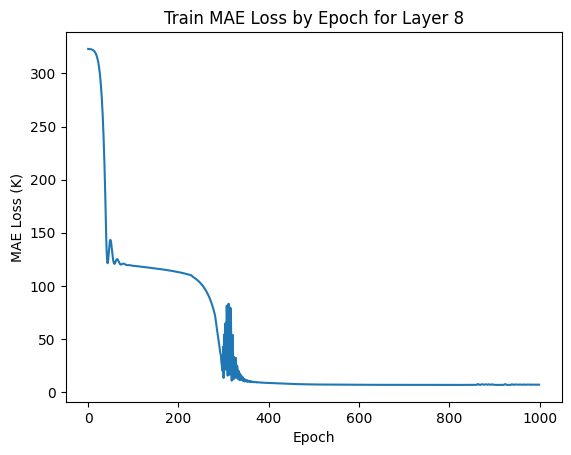

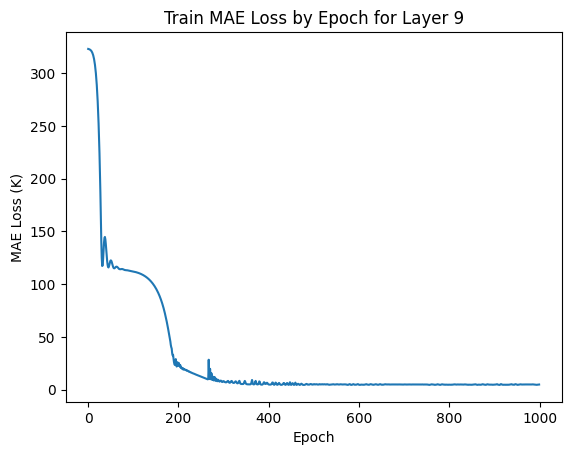

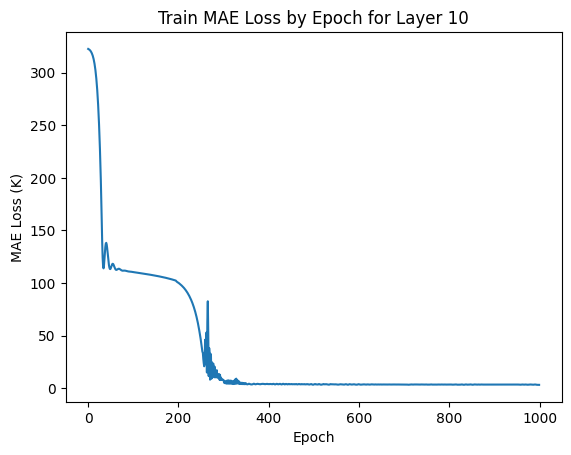

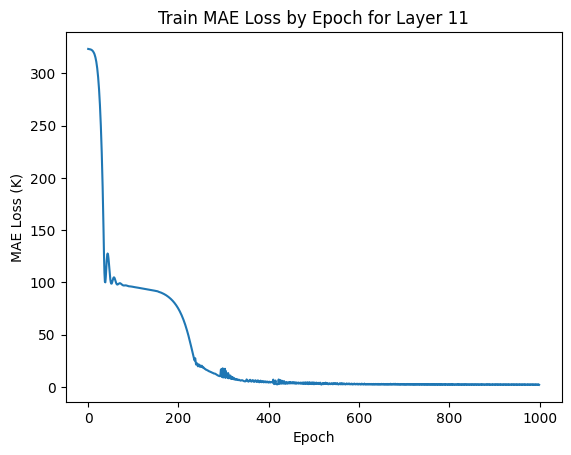

In [ ]:
for layer in layers:
    plt.plot(layer['train losses'])

    plt.title(f"Train MAE Loss by Epoch for {layer['col'].capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel("MAE Loss (K)")

    plt.show()

In [ ]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

layer 1 loss: 24.362234115600586
layer 2 loss: 13.9110689163208
layer 3 loss: 10.58865737915039
layer 4 loss: 10.297292709350586
layer 5 loss: 10.667981147766113
layer 6 loss: 10.228446006774902
layer 7 loss: 9.249128341674805
layer 8 loss: 7.167305946350098
layer 9 loss: 5.310379981994629
layer 10 loss: 3.484307050704956
layer 11 loss: 2.280252695083618


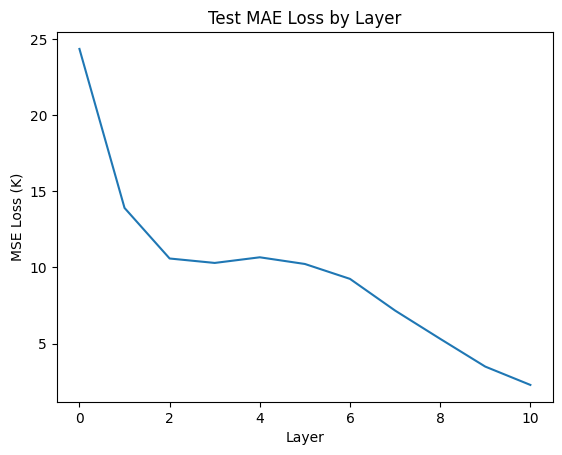

In [ ]:
plt.plot(test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [ ]:
def plot_comparison(pred, actual):
    plt.title("Temperature Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("Temperature")
    plt.plot(pred, 'r+', label='predicted')
    plt.plot(actual, 'g', label='actual')
    plt.show()

In [ ]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

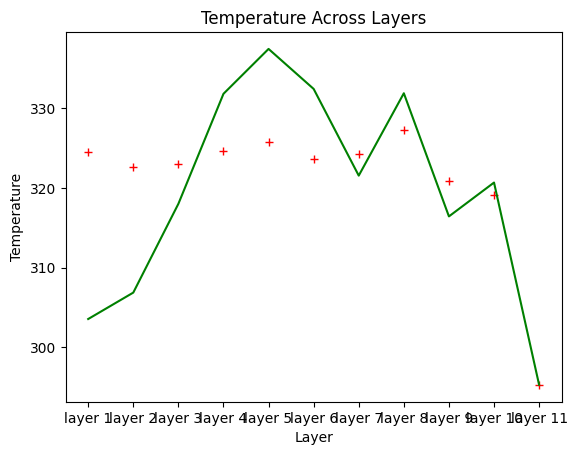

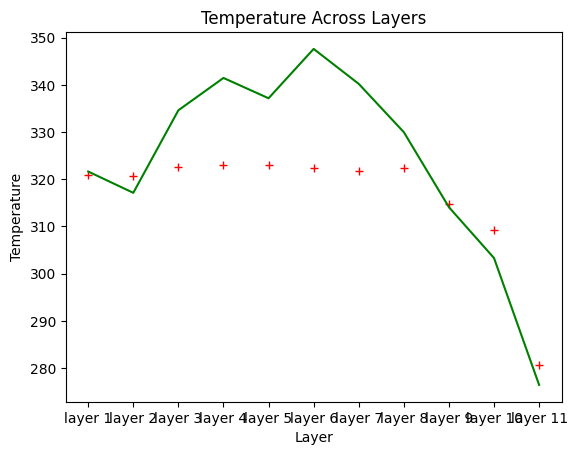

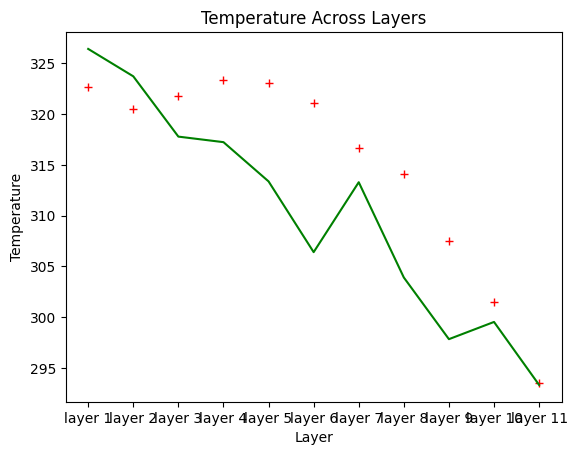

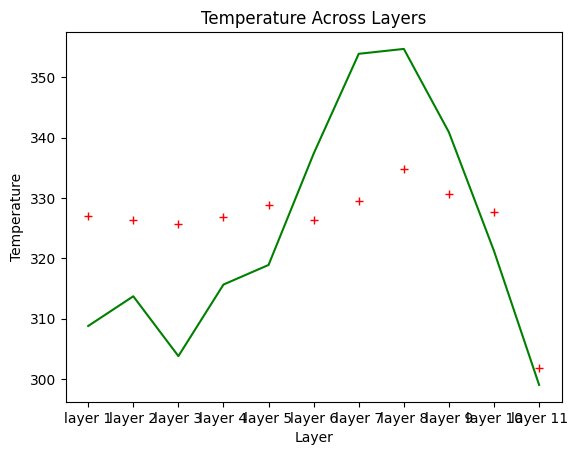

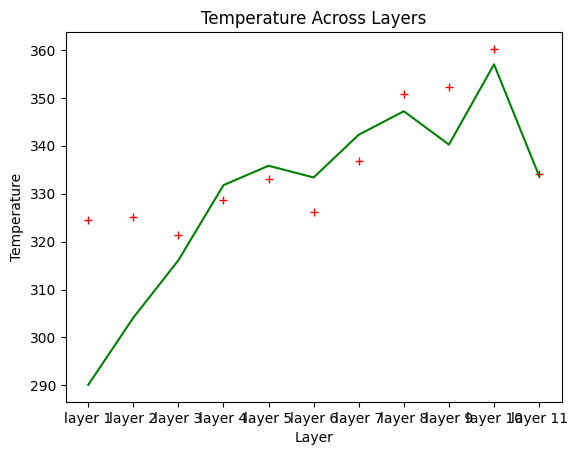

In [ ]:


for i in range(0, len(y_test), int(len(y_test)/5)):
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual)